## Diabetes Prediction

Dataset: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. This dataset can be used to build machine learning models to predict diabetes in patients based on their medical history and demographic information. This can be useful for healthcare professionals in identifying patients who may be at risk of developing diabetes and in developing personalized treatment plans. Additionally, the dataset can be used by researchers to explore the relationships between various medical and demographic factors and the likelihood of developing diabetes.

In [1]:
# data preprocessing and storage
import pandas as pd
import numpy as np
# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# modelling 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## EDA

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.columns = [i.lower().replace(' ', '_') for i in df.columns]
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,hba1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   hba1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.3+ MB


In [5]:
df.gender.value_counts()

Female    56161
Male      39967
Other        18
Name: gender, dtype: int64

Let's exclude entries w/o gender specified and create binary gender variable

In [6]:
df.drop(df[df['gender']=='Other'].index, inplace=True)
df['gender'] = df.gender.map({'Female': 0, 'Male': 1})

In [7]:
df.smoking_history.value_counts()

never          34395
No Info        32881
former          9299
current         9197
not current     6359
ever            3997
Name: smoking_history, dtype: int64

In [8]:
df.describe()

,gender,age,hypertension,heart_disease,bmi,hba1c_level,blood_glucose_level,diabetes
count,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000
mean,0.415769,41.796617,0.077615,0.040810,27.321450,5.532633,138.218001,0.088237
std,0.492857,22.463329,0.267567,0.197851,6.767811,1.073225,40.911190,0.283640
min,0.000000,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,1.000000,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [9]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
hba1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Let's check how features are correlated with the target variable (diabetes)

In [10]:
df.corr(numeric_only=True)['diabetes']

gender                 0.037837
age                    0.264918
hypertension           0.195696
heart_disease          0.170701
bmi                    0.214951
hba1c_level            0.406446
blood_glucose_level    0.424366
diabetes               1.000000
Name: diabetes, dtype: float64

Let's check the multicollinearity of features and exclude features that are highly correlated with each other. For that we can use the correlation matrix

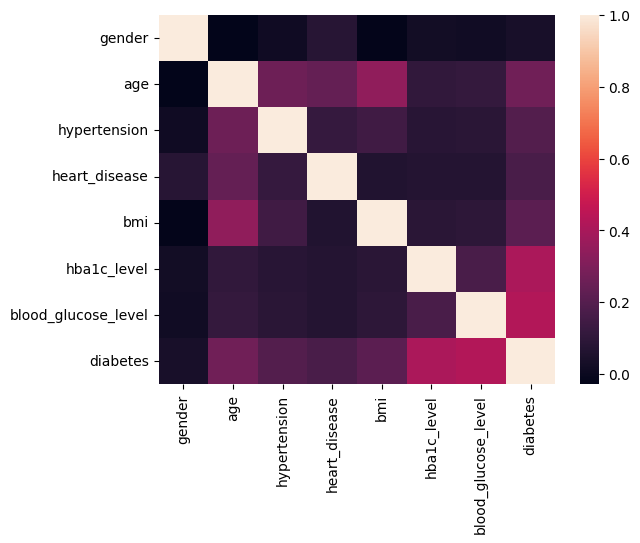

In [11]:
_ = sns.heatmap(df.corr(numeric_only=True))

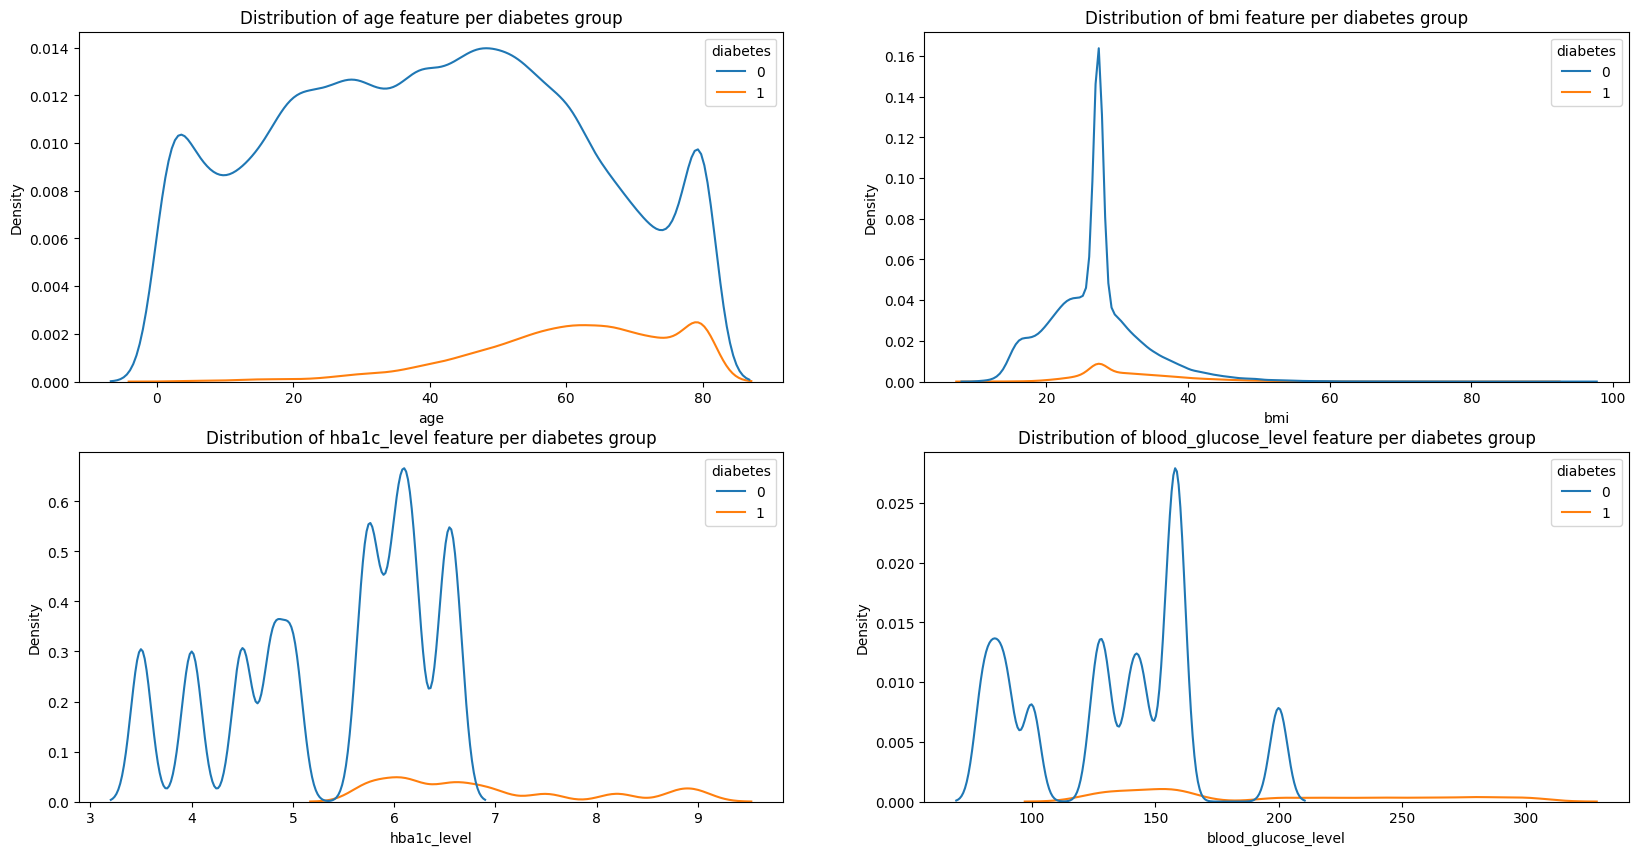

In [12]:
numeric_cols = ['age', 'bmi', 'hba1c_level', 'blood_glucose_level']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
counter = 0
for i in range(2):
    for j in range(2):
        column_name = numeric_cols[counter]
        _ = sns.kdeplot(x=column_name, hue='diabetes', data=df[[column_name, 'diabetes']], ax=ax[i, j])
        ax[i][j].set_title('Distribution of {} feature per diabetes group'.format(column_name))
        counter+=1

Let's split the dataframe into train, test and validation and separate X matrix and target variable

In [13]:
def x_y_split_and_index(df, y_column):
    df.reset_index(drop=True, inplace=True)
    cols_x = df.columns[df.columns!=y_column]
    X = df[cols_x].copy()
    y = df[y_column].values
    return X, y

In [14]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=42)
len(df_train), len(df_val), len(df_test)
del df_train_val
X_train, y_train = x_y_split_and_index(df_train, 'diabetes')
X_test, y_test = x_y_split_and_index(df_test, 'diabetes')
X_val, y_val = x_y_split_and_index(df_val, 'diabetes')

In [15]:
X_train.sample(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,hba1c_level,blood_glucose_level
28252,1,55.0,0,0,current,32.86,6.5,90
54405,0,80.0,0,0,never,27.32,4.5,85
51149,1,43.0,0,0,never,17.97,5.7,145
9021,0,30.0,0,0,never,24.41,5.7,90
20712,1,26.0,0,0,ever,25.99,6.6,85


In [16]:
df.diabetes.value_counts(normalize=True)*100

0    91.176348
1     8.823652
Name: diabetes, dtype: float64

The dataset is very imbalanced with only 8.8% of entries having diabetes, so it's better not to use accuracy metric. 

The models, that we will be testing, for predicting probabilities of diabetes:
* [Logistic regression](#logistic_regression)
* [Decision Trees](#decision_trees)
* [Random Forest](#random_forest)
* [Gradient Boosting](#gradient_boosting)

In [17]:
train_dicts = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(X_val.to_dict(orient='records'))

In [18]:
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    res = tn/(tn+fp)
    return res

### Logistic Regression
<a id="logistic_regression"></a>

In [19]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=7)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
binary_pred_1 = [1 if i>=0.5 else 0 for i in y_pred]
model1_f1 = f1_score(y_val, binary_pred_1)
model1_precision = precision_score(y_val, binary_pred_1)
model1_recall = recall_score(y_val, binary_pred_1)
model1_specificity = specificity(y_val, binary_pred_1)
model1_mcc = matthews_corrcoef(y_val, binary_pred_1)

In [20]:
results_df = pd.DataFrame()
df_temp = pd.DataFrame.from_dict({'model': ['log_reg'], 'f1': [model1_f1], 
                                  'precision': [model1_precision], 'recall': [model1_recall],
                                  'specificty': [model1_specificity], 'mcc': [model1_mcc]})
results_df = pd.concat([results_df, df_temp])
del df_temp

### Decison Trees
<a id="decison_trees"></a>

In [21]:
trees = DecisionTreeClassifier(max_depth=5, random_state=7)
trees.fit(X_train, y_train)
y_pred = trees.predict_proba(X_val)[:, 1]
binary_pred_2 = [1 if i>=0.5 else 0 for i in y_pred]
model2_f1 = f1_score(y_val, binary_pred_2)
model2_precision = precision_score(y_val, binary_pred_2)
model2_recall = recall_score(y_val, binary_pred_2)
model2_specificity = specificity(y_val, binary_pred_2)
model2_mcc = matthews_corrcoef(y_val, binary_pred_2)

df_temp = pd.DataFrame.from_dict({'model': ['decision_trees'], 'f1': [model2_f1], 
                                  'precision': [model2_precision], 'recall': [model2_recall],
                                  'specificty': [model2_specificity], 'mcc': [model2_mcc]})
results_df = pd.concat([results_df, df_temp])
del df_temp

Let's have a look at different depth of the trees

In [22]:
for i in range(2, 22, 5):
    tree_mdl = DecisionTreeClassifier(max_depth=i, random_state=7)
    tree_mdl.fit(X_train, y_train)
    y_pred = tree_mdl.predict_proba(X_val)[:, 1]
    binary_pred_temp = [1 if i>=0.5 else 0 for i in y_pred]
    mdl_temp_f1 = f1_score(y_val, binary_pred_temp)
    mdl_temp_precision = precision_score(y_val, binary_pred_temp)
    mdl_temp_recall = recall_score(y_val, binary_pred_temp)
    mdl_temp_specificity = specificity(y_val, binary_pred_temp)
    mdl_temp_mcc = matthews_corrcoef(y_val, binary_pred_temp)
    mdl_def = 'decision_tree_depth_{}'.format(i)

    df_temp = pd.DataFrame.from_dict({'model': [mdl_def], 'f1': [mdl_temp_f1], 
                                    'precision': [mdl_temp_precision], 'recall': [mdl_temp_recall],
                                    'specificty': [mdl_temp_specificity], 'mcc': [mdl_temp_mcc]})
    results_df = pd.concat([results_df, df_temp])
    del df_temp

### Random Forest
<a id="random_forest"></a>

In [23]:
forest = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=7)
forest.fit(X_train, y_train)
y_pred = forest.predict_proba(X_val)[:, 1]
binary_pred_3 = [1 if i>=0.5 else 0 for i in y_pred]
model3_f1 = f1_score(y_val, binary_pred_3)
model3_precision = precision_score(y_val, binary_pred_3)
model3_recall = recall_score(y_val, binary_pred_3)
model3_specificity = specificity(y_val, binary_pred_3)
model3_mcc = matthews_corrcoef(y_val, binary_pred_3)

df_temp = pd.DataFrame.from_dict({'model': ['random_forest'], 'f1': [model3_f1], 
                                  'precision': [model3_precision], 'recall': [model3_recall],
                                  'specificty': [model3_specificity], 'mcc': [model3_mcc]})
results_df = pd.concat([results_df, df_temp])
del df_temp

Let's try to tune the parameters using grid search

In [24]:
forest = RandomForestClassifier(random_state=7)
searcher = GridSearchCV(forest, {'n_estimators': range(50, 201, 50)
                                 , 'max_depth': range(2, 11, 3)
                                 , 'max_features': ['sqrt', 'log2']})
searcher.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=7),
             param_grid={'max_depth': range(2, 11, 3),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': range(50, 201, 50)})

In [25]:
searcher.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}

In [26]:
y_pred = searcher.predict_proba(X_val)[:, 1]
binary_pred_4 = [1 if i>=0.5 else 0 for i in y_pred]
model4_f1 = f1_score(y_val, binary_pred_4)
model4_precision = precision_score(y_val, binary_pred_4)
model4_recall = recall_score(y_val, binary_pred_4)
model4_specificity = specificity(y_val, binary_pred_4)
model4_mcc = matthews_corrcoef(y_val, binary_pred_4)

df_temp = pd.DataFrame.from_dict({'model': ['random_forest_gs'], 'f1': [model4_f1], 
                                  'precision': [model4_precision], 'recall': [model4_recall],
                                  'specificty': [model4_specificity], 'mcc': [model4_mcc]})
results_df = pd.concat([results_df, df_temp])
del df_temp

### Gradient Boosting
<a id="gradient_boosting"></a>

In [27]:
xgb = XGBClassifier(random_state=7, subsample=0.5, max_depth=7, eta=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_val)[:, 1]

binary_pred_5 = [1 if i>=0.5 else 0 for i in y_pred]
model5_f1 = f1_score(y_val, binary_pred_5)
model5_precision = precision_score(y_val, binary_pred_5)
model5_recall = recall_score(y_val, binary_pred_5)
model5_specificity = specificity(y_val, binary_pred_5)
model5_mcc = matthews_corrcoef(y_val, binary_pred_5)

df_temp = pd.DataFrame.from_dict({'model': ['xgboost'], 'f1': [model5_f1], 
                                  'precision': [model5_precision], 'recall': [model5_recall],
                                  'specificty': [model5_specificity], 'mcc': [model5_mcc]})
results_df = pd.concat([results_df, df_temp])
del df_temp

In [28]:
results_df

,model,f1,precision,recall,specificty,mcc
0,log_reg,0.735967,0.878412,0.633274,0.991623,0.726352
0,decision_trees,0.808526,1.000000,0.678593,1.000000,0.811401
0,decision_tree_depth_2,0.808526,1.000000,0.678593,1.000000,0.811401
0,decision_tree_depth_7,0.808526,1.000000,0.678593,1.000000,0.811401
0,decision_tree_depth_12,0.803144,0.940753,0.700656,0.995783,0.797326
0,decision_tree_depth_17,0.766011,0.804462,0.731067,0.983019,0.745830
0,random_forest,0.790916,1.000000,0.654144,1.000000,0.795749
0,random_forest_gs,0.808526,1.000000,0.678593,1.000000,0.811401
0,xgboost,0.811826,0.974124,0.695886,0.998234,0.810260


Let's evalute all models on test dataset and add results to the dataframe as well

In [29]:
X_test = dv.transform(X_test.to_dict(orient='records'))
# logistic regression
y_pred_test1 = model.predict(X_test)
# decision trees 
y_pred_test2 = trees.predict(X_test)
# random forest 
y_pred_test3 = searcher.predict(X_test)
# xgboost
y_pred_test4 = xgb.predict(X_test)

In [30]:
mdls = ['log_reg', 'decision_trees', 'random_forest', 'xgboost']
counter = 0
results = {}
for i in [y_pred_test1, y_pred_test2, y_pred_test3, y_pred_test4]:
    f1 = f1_score(y_test, i)
    precision = precision_score(y_test, i)
    recall = recall_score(y_test, i)
    specificity_ = specificity(y_test, i)
    mcc = matthews_corrcoef(y_test, i)
    results[mdls[counter]] = [f1, precision, recall, specificity_, mcc]
    counter+=1

test_results = pd.DataFrame(results).T.reset_index()
test_results.columns = results_df.columns
test_results

,model,f1,precision,recall,specificty,mcc
0,log_reg,0.718878,0.859362,0.617872,0.990185,0.707522
1,decision_trees,0.789755,1.000000,0.652557,1.000000,0.794524
2,random_forest,0.789755,1.000000,0.652557,1.000000,0.794524
3,xgboost,0.796380,0.976109,0.672546,0.998402,0.796378


The best model should be selected based on two scores: Matthews Correlation Coefficient (mcc), since it takes into consideration all confusion matrix fields and is good for evaluating imbalanced datasets, and recall, since it's better to show the risk of having diabetes and go to medical professionals rather than missing it.

On both validation and test datasets the best model is xgboost. Let's save save model and preprocessing to a file

In [33]:
import pickle

In [34]:
output = 'dv_and_xgboost_diabetes.bin'
with open(output, 'wb') as f_out:
    pickle.dump((dv, xgb), f_out)

Let's test the Docker and prediction app

In [9]:
import requests

url = 'http://localhost:9696/diabetes'
patient = {'gender': 0, 'age': 27, 'hypertension': 0, 'heart_disease': 1, 'smoking_history': 'never',
           'bmi': 25.1, 'hba1c_level': 4.0, 'blood_glucose_level': 98}
requests.post(url, json=patient).json()

{'predicted_score': ['no risk']}